# From a Single Tree to a Forest: The Story of Ensemble Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn Models and Utilities
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# State-of-the-art Boosting Libraries
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

## 📖 Section 1: The Building Block: The Decision Tree

### What is a Decision Tree? (The "20 Questions" Analogy)
Imagine you're playing the game "20 Questions." You try to guess an object by asking a series of simple yes/no questions. A Decision Tree works in the exact same way. It's essentially a flowchart that asks a sequence of simple questions about your data to arrive at a conclusion or a prediction. 🌳

For our dataset, which is about classifying breast cancer tumors, a question might be, *"Is the `worst_radius` of the tumor greater than 17.5?"* Based on the answer, we follow a path down the tree to the next question, until we reach a final answer: `malignant` or `benign`.

### Core Mechanics & Terminology
Let's define the key parts of a tree:
- **Root Node**: The very first question, which splits all the data.
- **Decision Node**: Any subsequent node that asks a question and splits the data further.
- **Branches**: The arrows connecting nodes, representing the path taken based on the answer to a question.
- **Leaf Node**: A terminal node that doesn't split further. This is where the final prediction is made.

A tree "learns" by finding the questions (splits) that best separate the data into the purest possible groups. It measures this purity using a metric like **Gini Impurity** or **Entropy**. A Gini impurity of 0 means a node is perfectly pure (e.g., all samples in it are `malignant`).

First, let's load our data and split it into training and testing sets.

In [2]:
# Load the dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target # 0: malignant, 1: benign

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### ⚠️ The Big Problem: Overfitting
A single decision tree, if left to grow unchecked, can become incredibly deep and complex. It will keep asking questions until it has perfectly classified every single data point in the training set. This sounds good, but it's actually a major problem. The tree "memorizes" the training data, including its noise and quirks, and fails to generalize to new, unseen data.

Let's demonstrate this by training a very deep tree.

In [3]:
# Train a single, deep Decision Tree
# By not setting max_depth, we let it grow as much as it wants.
deep_tree = DecisionTreeClassifier(random_state=42)
deep_tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Now, we'll evaluate its performance. Notice the huge gap between training accuracy and testing accuracy. This is the classic sign of overfitting.

In [4]:
# Predictions
y_train_pred = deep_tree.predict(X_train)
y_test_pred = deep_tree.predict(X_test)

# Evaluate
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Testing Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")

print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_test_pred, target_names=data.target_names))

Training Accuracy: 1.0000
Testing Accuracy:  0.9415

--- Test Set Classification Report ---
              precision    recall  f1-score   support

   malignant       0.90      0.95      0.92        63
      benign       0.97      0.94      0.95       108

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



Visualizing this tree would be impossible because it's so massive. Let's visualize a simpler, pruned tree (`max_depth=3`) to see the structure.

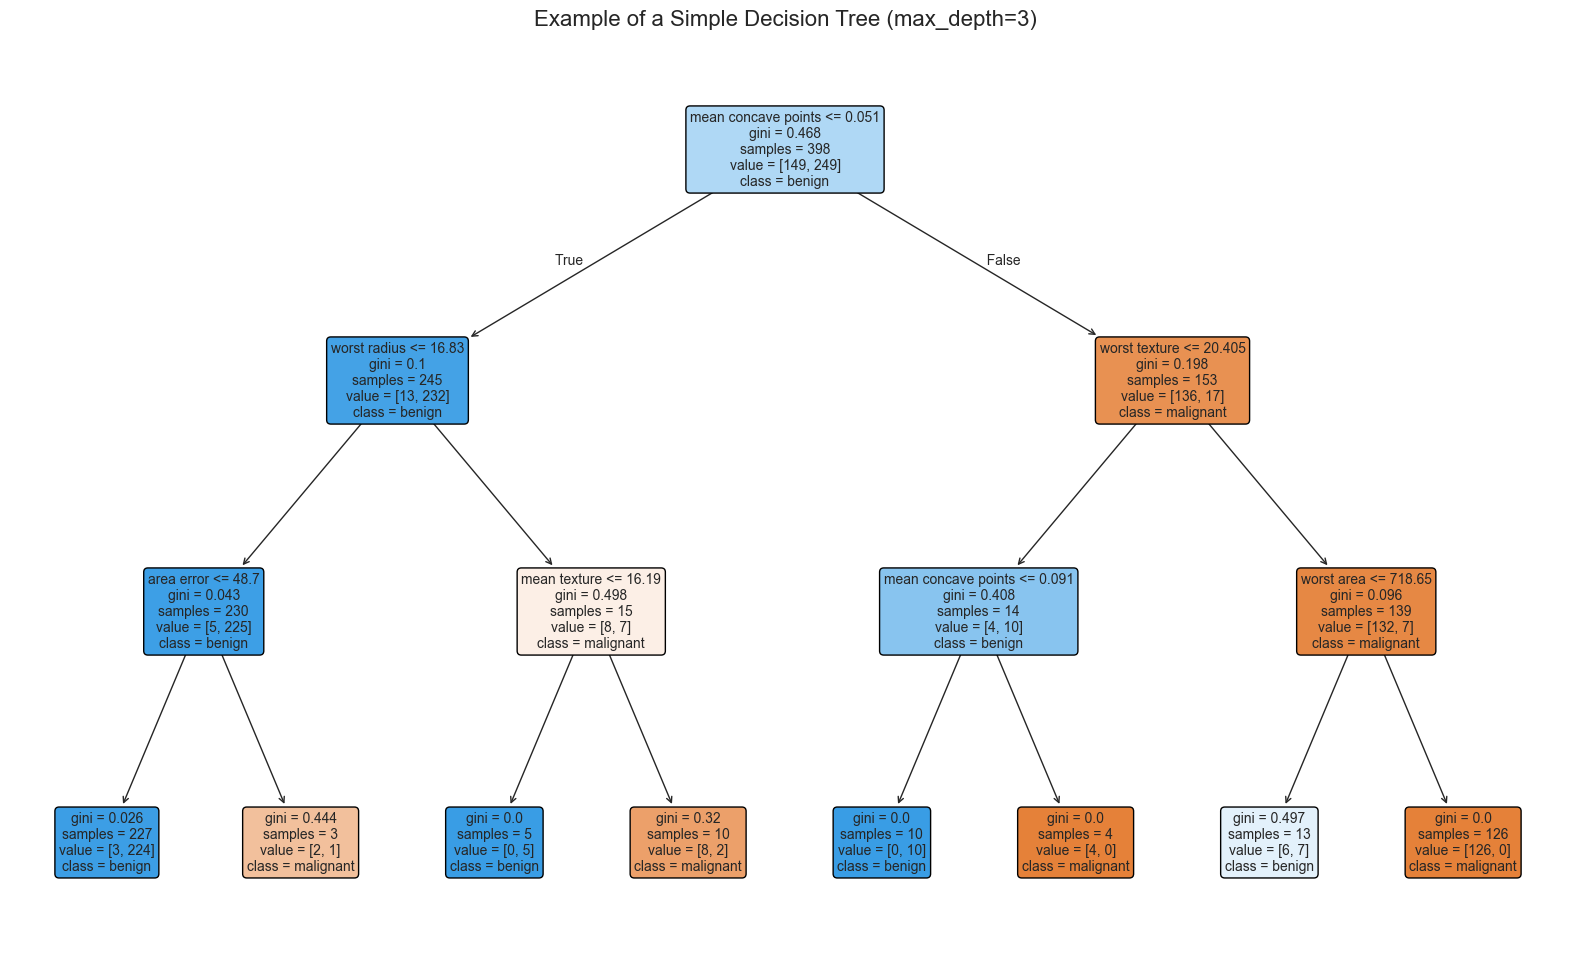

In [5]:
plt.figure(figsize=(20, 12))
plot_tree(DecisionTreeClassifier(max_depth=3, random_state=42).fit(X_train, y_train), 
          filled=True, 
          feature_names=data.feature_names, 
          class_names=data.target_names, 
          rounded=True, 
          fontsize=10)
plt.title("Example of a Simple Decision Tree (max_depth=3)", fontsize=16)
plt.show()

The tendency of single trees to overfit is the primary motivation for using **ensemble models**.

## 🧠 Section 2: The Wisdom of the Crowd (An Introduction to Ensemble Learning)

### The Core Idea
The central idea behind ensemble learning is beautifully simple. 
> Instead of relying on a single expert, who might have biases or make mistakes, we ask a large, diverse committee of experts and take their collective vote. The committee's decision is almost always more robust and accurate than any individual's.

In machine learning, our "experts" are our models (like decision trees). By combining many of them, we can create a single, much stronger model.

### The Two Main Strategies
There are two dominant strategies for creating an ensemble:

- **Bagging (Bootstrap Aggregating):** This is the strategy of creating a "committee" of independent experts. We train many models in parallel, each on a different random subset of the data. Their final prediction is made by a majority vote. The goal of bagging is to **reduce variance** and prevent overfitting. **Random Forest** is the most famous bagging algorithm.

- **Boosting:** This is the strategy of creating a "team" of specialists that learn sequentially. The first model makes a prediction. The second model is then trained specifically to fix the errors of the first. The third model fixes the errors of the second, and so on. The goal of boosting is to **reduce bias** and create a very powerful, accurate model. **Gradient Boosting** is the most famous boosting algorithm.

## 🌲 Section 3: Random Forest: The Power of Diversity

### The Algorithm
A Random Forest is an ensemble of decision trees that uses bagging with a clever twist to ensure the "committee" of trees is diverse.

1. It builds hundreds of decision trees, each on a different random sample of the training data (this is the **bootstrap aggregating** or "bagging" part).
2. Crucially, at each split in each tree, it only considers a **random subset of the features** to make its decision.

### Analogy: The Specialized Committee
> Imagine a committee of doctors diagnosing a tumor. Instead of every doctor seeing all the patient's data, each doctor is only shown a random selection of test results (e.g., one sees only radius and texture, another sees only perimeter and smoothness). This forces them to become 'specialists' and prevents the entire committee from being overly influenced by one or two dominant test results. This randomness promotes diversity among the trees, and a diverse committee is a strong committee.

Let's train a `RandomForestClassifier`. Notice how its performance is more stable and better than the single overfit tree.

In [6]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Now we evaluate the Random Forest's performance.

In [7]:
# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
print(f"Random Forest Testing Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred_rf, target_names=data.target_names))

Random Forest Testing Accuracy: 0.9708

--- Test Set Classification Report ---
              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        63
      benign       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



The test accuracy is much higher and more reliable. The key hyperparameters to tune are `n_estimators` (the number of trees in the forest) and `max_features` (the number of features to consider at each split).

## 📈 Section 4: Gradient Boosting: Learning from Mistakes

### The Algorithm
Gradient Boosting takes a completely different approach. It builds trees sequentially, where each new tree corrects the errors of the previous ones.

1.  Train a very simple, "weak" learner (e.g., a tree with a depth of 1 or 2).
2.  Calculate the errors (residuals) that this first tree made.
3.  Train a *second* tree whose goal is to **predict the errors** of the first tree.
4.  Combine the predictions of the first and second trees. The new combined prediction is better than the first one alone.
5.  Repeat this process, sequentially adding new trees that correct the remaining errors of the entire ensemble.

### Analogy: The Assembly Line of Experts
> Imagine an assembly line for diagnosis. The first doctor makes a quick, initial assessment. The second doctor doesn't re-do the whole diagnosis but instead looks at the first doctor's notes and focuses only on correcting their potential mistakes. A third doctor then refines the second's corrections. The final diagnosis is the sum of this sequential, error-correcting process.

Let's train scikit-learn's `GradientBoostingClassifier`.

In [8]:
# Train a GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


Now, we'll evaluate the Gradient Boosting model.

In [9]:
# Predictions
y_pred_gb = gb.predict(X_test)

# Evaluate
print(f"Gradient Boosting Testing Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")

print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred_gb, target_names=data.target_names))

Gradient Boosting Testing Accuracy: 0.9591

--- Test Set Classification Report ---
              precision    recall  f1-score   support

   malignant       0.95      0.94      0.94        63
      benign       0.96      0.97      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



Key hyperparameters include `n_estimators`, `learning_rate` (how much each new tree contributes to the ensemble), and `max_depth` (the complexity of each weak learner).

## 🚀 Section 5: XGBoost: The Champion of Boosting

### What Makes it "eXtreme"?
XGBoost (eXtreme Gradient Boosting) is not a fundamentally new concept. It is a highly **optimized and engineered implementation** of the Gradient Boosting algorithm, with several new features that make it incredibly fast and effective. It's famous for its dominance in machine learning competitions on tabular data.

### Analogy: The Supercharged Engine
> If Gradient Boosting is a powerful car engine, XGBoost is that same engine, but it has been professionally rebuilt by a team of race engineers with a turbocharger (speed), better brakes (regularization), and an advanced onboard computer (smarter algorithms).

### Key Improvements
- **Regularization**: It includes L1 and L2 regularization terms in its objective function, which directly fights overfitting—a major advantage over standard Gradient Boosting.
- **Computational Efficiency**: It is designed for speed and can be parallelized, making it much faster.
- **Handling Missing Values**: It has a built-in, intelligent way of handling missing data.

Let's train an `XGBClassifier`.

In [10]:
# Train an XGBClassifier
# Note: XGBoost has its own API, but the scikit-learn wrapper is very convenient.
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

c:\Users\jspag\VSProjects\notebooks\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:44:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


And now we evaluate it.

In [11]:
# Predictions
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate
print(f"XGBoost Testing Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred_xgb, target_names=data.target_names))

XGBoost Testing Accuracy: 0.9532

--- Test Set Classification Report ---
              precision    recall  f1-score   support

   malignant       0.95      0.92      0.94        63
      benign       0.95      0.97      0.96       108

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



## ✨ Section 6: Other Key Variations: LightGBM & CatBoost

Two other state-of-the-art libraries are often used alongside or in place of XGBoost.

- **LightGBM (Light Gradient Boosting Machine):**
  - **Key Idea:** Grows trees *leaf-wise* (choosing the leaf it believes will yield the largest reduction in loss) instead of *level-wise* (like XGBoost). This makes it extremely fast and often more accurate, but it can be more prone to overfitting on smaller datasets.

- **CatBoost (Categorical Boosting):**
  - **Key Idea:** Its superpower is its novel, highly effective built-in method for handling **categorical features**, which often outperforms traditional one-hot encoding. It is also known for being robust and requiring less hyperparameter tuning.

Let's quickly train a model from each library for comparison.

In [12]:
# Train LightGBM
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)
y_pred_lgb = lgb_clf.predict(X_test)
print(f"LightGBM Testing Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")

# Train CatBoost
cat_clf = cb.CatBoostClassifier(random_state=42, verbose=0) # verbose=0 suppresses training output
cat_clf.fit(X_train, y_train)
y_pred_cat = cat_clf.predict(X_test)
print(f"CatBoost Testing Accuracy: {accuracy_score(y_test, y_pred_cat):.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 249, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3978
[LightGBM] [Info] Number of data points in the train set: 398, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625628 -> initscore=0.513507
[LightGBM] [Info] Start training from score 0.513507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## 🛠️ Section 7: Practical Guide & Interpretation

### Feature Scaling: Not Required!
A major practical advantage of tree-based models is that they are **not sensitive to the scale of features**. Because they make decisions by finding the best split point for a feature (e.g., "is `radius` > 17.5?"), it doesn't matter if the radius is measured in millimeters or meters. This saves you the step of having to use `StandardScaler` or `MinMaxScaler`.

### Feature Importance
Even though ensemble models are complex, they can provide a very useful summary of which features were most important for making predictions. We can easily plot the `feature_importances_` attribute from a trained model.

This plot shows us which features the model found most predictive for classifying tumors. This makes these powerful "black box" models more interpretable.

C:\Users\jspag\AppData\Local\Temp\ipykernel_28760\310412726.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')


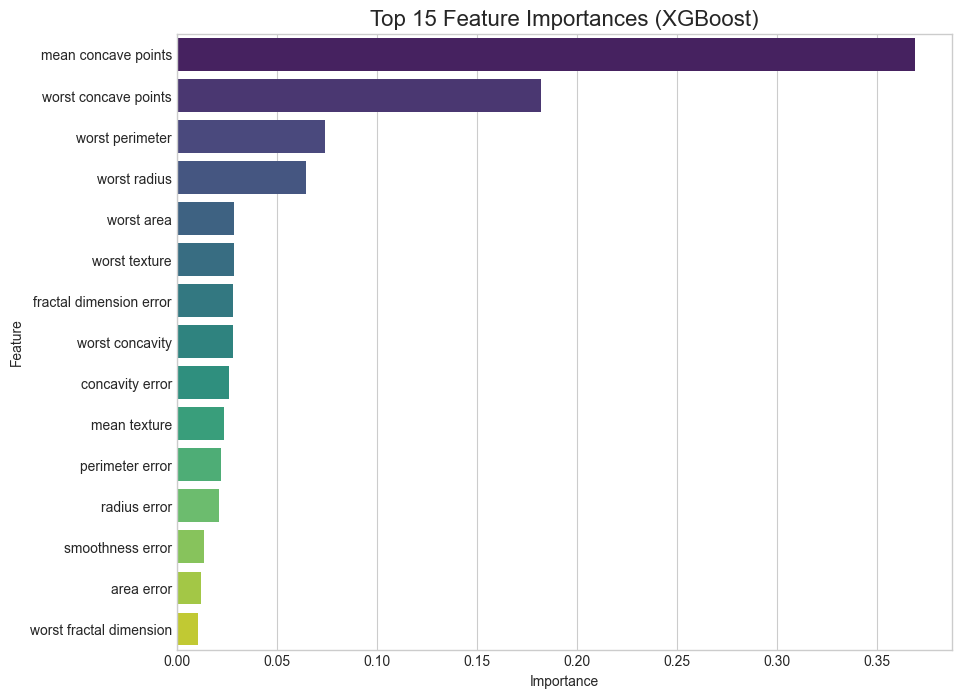

In [13]:
# Get feature importances from the XGBoost model
importances = xgb_clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False).head(15) # Top 15 features

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Hyperparameter Tuning
To get the best performance from boosting models, you often need to tune their hyperparameters. A full `GridSearchCV` can be slow, so `RandomizedSearchCV` is a great, efficient alternative. It samples a fixed number of parameter combinations from a specified distribution.

Let's find better hyperparameters for our XGBoost model.

In [14]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Subsample ratio of columns when constructing each tree
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]      # Subsample ratio of the training instance
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_grid,
    n_iter=50, # Number of parameter settings that are sampled
    cv=5,      # 5-fold cross-validation
    verbose=0, 
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model
random_search.fit(X_train, y_train)

c:\Users\jspag\VSProjects\notebooks\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:45:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.7, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200, ...], ...}"
,n_iter,50
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


Let's see the best parameters and the improved score.

In [15]:
print(f"Best Parameters Found: {random_search.best_params_}")
print(f"Best Cross-validation Accuracy: {random_search.best_score_:.4f}")

# Evaluate the best model on the test set
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)
print(f"Tuned XGBoost Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")

Best Parameters Found: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best Cross-validation Accuracy: 0.9723
Tuned XGBoost Test Accuracy: 0.9708


## ✅ Section 8: Conclusion: Which Model Should I Use?

Here's a simple guide for choosing your model:

- **Decision Tree**:
  - **Use When**: You need a simple, highly interpretable baseline or need to explain the model's logic easily to non-technical stakeholders.
  - **Downside**: Prone to overfitting and generally not very accurate.

- **Random Forest**:
  - **Use When**: You need a strong, robust, all-around model. It's hard to mess up, requires less tuning than boosting models, and is a great first choice for getting a strong result quickly.
  - **Downside**: Can be slower and consume more memory than boosting models. May not reach the absolute peak performance.

- **Gradient Boosting / XGBoost / LightGBM**:
  - **Use When**: Your primary goal is maximum accuracy. These models consistently provide state-of-the-art performance on tabular data and are famous for winning Kaggle competitions.
  - **Downside**: They have more hyperparameters and require more careful tuning to avoid overfitting. They can be more sensitive to noisy data than Random Forests.